<a href="https://colab.research.google.com/github/ferjorosa/learn-fastai/blob/main/basic_mnist_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic MNIST example**

The objective of this notebook is to simply put my notes and examples of the MNIST example of Chapter 4 from the Fast AI book

### Installation

In [1]:
#hide (Google Colab)
!pip install fastai --upgrade -q
import fastai
print(fastai.__version__)

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 189 kB 29.3 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
2.5.3
     |████████████████████████████████| 720 kB 33.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.6 MB/s 
     |████████████████████████████████| 51 kB 335 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

### **Data**

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [4]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [5]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [6]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### **Single-batch gradient descent**

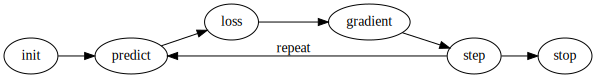

In [7]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [8]:
train_x =torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([0] * len(stacked_threes) + [1] *len(stacked_sevens)).unsqueeze(1)
(train_x.shape, train_y.shape)

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [9]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1,28*28)
valid_y = tensor([0] * len(valid_3_tens) + [1] * len(valid_7_tens)).unsqueeze(1)
(valid_x.shape, valid_y.shape)

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [112]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()

def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def linear3(x, w): return x@w + intercept
  
def predict(x, w):
  linear_predictions = model(x, w)
  predictions = linear_predictions.sigmoid()
  return torch.where(predictions > 0.5, 1, 0)

def validate(valid_x, w, valid_y):
  binary_preds = predict(valid_x, w)
  return (binary_preds == valid_y).count_nonzero() / valid_y.shape[0]

def epoch1(x, y, w, valid_x, valid_y, prt=True):
  pred = model(x, w)
  loss = mnist_loss(pred, y)
  loss.backward()
  if prt: print("Loss: " + str(loss))
  accuracy = validate(valid_x, w, valid_y)
  if prt: print("Validation accuracy: " + str(accuracy))
  w.data -= w.grad.data * lr

w = init_params((784, 1))
lr = 1e-3
model = linear3
weights = init_params((28*28,1))
intercept = init_params(1)

In [20]:
epoch1(train_x, train_y, w, valid_x, valid_y)

Loss: tensor(0.3460, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.6541)


In [113]:
n_epochs = 100
for i in range (1, n_epochs):
  epoch1(train_x, train_y, w, valid_x, valid_y)

Loss: tensor(0.2047, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2047, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2046, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2046, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2045, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2045, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2044, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2043, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2042, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2041, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2039, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2038, grad_fn=<MeanBackward0>)
Validation accuracy: tensor(0.8209)
Loss: tensor(0.2

### **Stochastic gradient descent**

When working with gradient descent it may be interesting to consider only a hadful of batches at each iteration. We can do this with Fast AI in a ver simple
manner with the *DataLoader* class.

In the following implementation, each epoch considers all of the data. However, **each epoch updates the parameters multiple times** by considering all of the data in batch form in random order. 

**Note on theory:** I am not completely sure this is the traditional way of doing SGD, but it was the intuition I obtained from reading the AI book

**Note on speed:** Previous implementation is much faster. I suppose due to the absence of the multiple for loops that are here

In [13]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(train_x, train_y))

In [106]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
xb, yb = first(train_dl)
print(xb.shape, yb.shape)

valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)
xb, yb = first(valid_dl)
print(xb.shape, yb.shape)

torch.Size([256, 784]) torch.Size([256, 1])
torch.Size([256, 784]) torch.Size([256, 1])


In [107]:
class LinearModel:

  def __init__(self, intercept, weights):
    self.intercept = intercept
    self.weights = weights
    self.params = (intercept, weights)

  def predict(self, data):
    return data@self.weights + self.intercept


def mnist_loss(predictions, targets): 
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

def calc_grad(xb, yb, model, prt=True):
  pred = model.predict(xb)
  loss = mnist_loss(pred, yb)
  loss.backward()
  if prt: print("Loss: " + str(loss))

def train_epoch(train_dl, model, lr, prt=True):
  for xb, yb in train_dl: # Iterates over batches, not individual instances
    calc_grad(xb, yb, model, prt)
    for p in model.params:
      p.data -= p.grad * lr
      p.grad.zero_() # See page 172, last paragraph
  
def hard_predict_mnist(xb, model):
  linear_predictions = model.predict(xb)
  predictions = linear_predictions.sigmoid()
  return torch.where(predictions > 0.5, 1, 0)

def validate_epoch(valid_dl, model):
  batch_accs = [(hard_predict_mnist(valid_xb, model) == valid_yb).count_nonzero() / valid_yb.shape[0] for valid_xb, valid_yb in valid_dl]
  return torch.FloatTensor(batch_accs).mean()

In [36]:
# Small example just to see what was happening under the hood
# xb and yb are now batches, not individual data instances

# l = []
# for xb, yb in train_dl:
#   l.append(xb)
# len(l)

5

In [ ]:
weights = init_params((28*28,1))
intercept = init_params(1)
linear_model = LinearModel(intercept, weights)

for i in range(1, 100):
  train_epoch(train_dl, linear_model, 1e-3, False)
  validation_acc = validate_epoch(valid_dl, linear_model)
  print("Epoch validation accuracy: " + str(validation_acc))

### **Creating an optimizer**